In [5]:
from gekko import GEKKO
import numpy as np
from random import random
import matplotlib.pyplot as plt


In [10]:
# Initialize Model
m = GEKKO()
m.time = np.linspace(0,100,101)

# Define constants
#Reflux Ratio
# rr = m.MV(value=6, lb=0, ub=10)
# rr.STATUS = 1  # allow optimizer to change
# rr.DMAX = 1   # slow down change of variable


# Feed flowrate (mol/min)
Feed=m.Const(value=3)
# Mole fraction of feed
x_Feed=m.Const(value=.5)
#Relative volatility = (yA/xA)/(yB/xB) = KA/KB = alpha(A,B)
vol=m.Const(value=1.6)
# Total molar holdup on each tray
atray=m.Const(value=.25)
# Total molar holdup in condenser
acond=m.Const(value=.5)
# Total molar holdup in reboiler
areb=m.Const(value=.1)
# mole fraction of component A
x=[]
for i in range(32):
    x.append(m.Var(.3))
# Define intermediates
# Distillate flowrate (mol/min)
D=m.Intermediate(.5*Feed)
# Liquid flowrate in rectification section (mol/min)
L=m.Intermediate(rr*D)
# Vapor Flowrate in column (mol/min)
V=m.Intermediate(L+D)

# Liquid flowrate in stripping section (mol/min)
FL=m.Intermediate(Feed+L)

# vapor mole fraction of Component A
y=[]
for i in range(32):
    y.append(m.Intermediate(x[i]*vol/(1+(vol-1)*x[i])))
# condenser
m.Equation(acond*x[0].dt()==V*(y[1]-x[0]))
# 15 column stages
n=1
for i in range(15):
    m.Equation(atray * x[n].dt() ==L*(x[n-1]-x[n]) - V*(y[n]-y[n+1]))
    n=n+1
# feed tray
m.Equation(atray * x[16].dt() == Feed*x_Feed + L*x[15] - FL*x[16] - V*(y[16]-y[17]))
# 14 column stages
n=17
for i in range(14):
    m.Equation(atray * x[n].dt() == FL*(x[n-1]-x[n]) - V*(y[n]-y[n+1]))
    n=n+1
# reboiler
m.Equation(areb  * x[31].dt() == FL*x[30] - (Feed-D)*x[31] - V*y[31])
# steady state solution

x[1] = m.MV(value=.4, lb=0, ub=1)
x[1].STATUS = 1  # allow optimizer to change
# y[1].DCOST = 0.1 # smooth out gas pedal movement
x[1].DMAX = 1   # slow down change of gas pedal

In [11]:
# Manipulated variable
#rr = m.MV(value=5, lb=0, ub=10)
# rr.STATUS = 1  # allow optimizer to change
# rr.DCOST = 0.1 # smooth out gas pedal movement
# rr.DMAX = 20   # slow down change of gas pedal

# Controlled Variable
rr = m.CV(value=6)
rr.STATUS = 1  # add the SP to the objective
m.options.CV_TYPE = 2 # squared error
rr.SP = 3.74     # set point
rr.TR_INIT = 6 # set point trajectory
rr.TAU = 4    # time constant of trajectory

In [12]:
m.options.IMODE = 6 # control
m.solve(disp=False)

# get additional solution information
import json
with open(m.path+'//results.json') as f:
    results = json.load(f)


# plt.figure()
# plt.subplot(2,1,1)
# plt.plot(m.time,rr.value,'b-',label='Reflux Ratio Optimized')
# plt.legend()
# plt.ylabel('Reflux Ratio')
# plt.subplot(2,1,2)
# plt.plot(m.time,results['v5'],'k-',label='Reference Trajectory')
# plt.plot(m.time,y[1].value,'r--',label='Composition of Tray 1')
# plt.ylabel('Output')
# plt.xlabel('Time')
# plt.legend(loc='best')

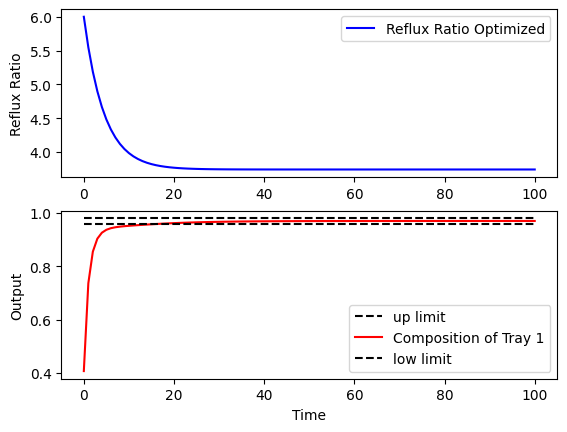

In [19]:
up_limit= np.ones(101)*0.98
low_limit= np.ones(101)*0.96

plt.figure()
plt.subplot(2,1,1)
plt.plot(m.time,rr.value,'b-',label='Reflux Ratio Optimized')
plt.legend()
plt.ylabel('Reflux Ratio')
plt.subplot(2,1,2)
# plt.plot(m.time[0:101], up_limit,'r:',label='U')
# plt.plot(m.time[0:101],y[1][0:101],'b-',label='Tray 1')
# plt.plot(m.time[0:101], low_limit,'r:',label='L')
plt.plot(m.time,up_limit,'k--',label='up limit')
plt.plot(m.time,y[1].value,'r-',label='Composition of Tray 1')
plt.plot(m.time,low_limit,'k--',label='low limit')
#plt.plot(m.time,results['v34.tr'],'r--',label='Composition of Tray 1')
plt.ylabel('Output')
plt.xlabel('Time')
plt.legend(loc='best')

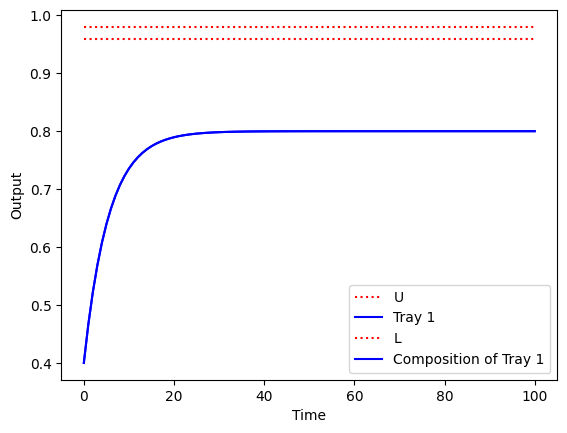

In [35]:
plt.plot(m.time, up_limit,'r:',label='U')
plt.plot(m.time,y[1],'b-',label='Tray 1')
plt.plot(m.time, low_limit,'r:',label='L')
plt.plot(m.time,y[1],'b-',label='Composition of Tray 1')
plt.ylabel('Output')
plt.xlabel('Time')
plt.legend(loc='best')

In [ ]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(m.time,rr.value,'b-',label='Reflux Ratio Optimized')
plt.legend()
plt.ylabel('Reflux Ratio')
plt.subplot(2,1,2)
plt.plot(m.time[0:101], up_limit,'r:',label='U')
plt.plot(m.time[0:101],y[1][0:101],'b-',label='Tray 1')
plt.plot(m.time[0:101], low_limit,'r:',label='L')
plt.plot(m.time,results['v33.sp'],'k-',label='Reference Trajectory')
plt.plot(m.time,results['v33'],'b-',label='Composition of Tray 1')
plt.plot(m.time,results['v33.tr'],'y-',label='trajactory')
#plt.plot(m.time,results['v34.tr'],'r--',label='Composition of Tray 1')
plt.ylabel('Output')
plt.xlabel('Time')
plt.legend(loc='best')

### **Test**

In [99]:
# Initialize Model
m = GEKKO()
m.time = np.linspace(0,100,101)

# Define constants
#Reflux Ratio manipulated variable
rr = m.MV(value=2, lb=0, ub=10)
rr.STATUS = 10  # allow optimizer to change
rr.DCOST= 1
rr.DMAX = 1  # slow down change of variable

# Controlled Variable
y[1] = m.CV(value=0.4)
y[1].STATUS = 1  # add the SP to the objective
m.options.CV_TYPE = 2 # squared error
y[1].SP = 0.97    # set point
y[1].TR_INIT = 0.97 # set point trajectory
y[1].TAU = 0.5    # time constant of trajectory

# Feed flowrate (mol/min)
Feed=m.Const(value=3)
# Mole fraction of feed
x_Feed=m.Const(value=.5)
#Relative volatility = (yA/xA)/(yB/xB) = KA/KB = alpha(A,B)
vol=m.Const(value=1.6)
# Total molar holdup on each tray
atray=m.Const(value=.25)
# Total molar holdup in condenser
acond=m.Const(value=.5)
# Total molar holdup in reboiler
areb=m.Const(value=.1)
# mole fraction of component A
x=[]
for i in range(32):
    x.append(m.Var(.3))
# Define intermediates
# Distillate flowrate (mol/min)
D=m.Intermediate(.5*Feed)
# Liquid flowrate in rectification section (mol/min)
L=m.Intermediate(rr*D)
# Vapor Flowrate in column (mol/min)
V=m.Intermediate(L+D)

# Liquid flowrate in stripping section (mol/min)
FL=m.Intermediate(Feed+L)

# vapor mole fraction of Component A
y=[]
for i in range(32):
    y.append(m.Intermediate(x[i]*vol/(1+(vol-1)*x[i])))
# condenser
m.Equation(acond*x[0].dt()==V*(y[1]-x[0]))
# 15 column stages
n=1
for i in range(15):
    m.Equation(atray * x[n].dt() ==L*(x[n-1]-x[n]) - V*(y[n]-y[n+1]))
    n=n+1
# feed tray
m.Equation(atray * x[16].dt() == Feed*x_Feed + L*x[15] - FL*x[16] - V*(y[16]-y[17]))
# 14 column stages
n=17
for i in range(14):
    m.Equation(atray * x[n].dt() == FL*(x[n-1]-x[n]) - V*(y[n]-y[n+1]))
    n=n+1
# reboiler
m.Equation(areb  * x[31].dt() == FL*x[30] - (Feed-D)*x[31] - V*y[31])
# steady state solution




In [100]:
m.options.IMODE = 6 # control
m.solve(disp=False)

# get additional solution information
import json
with open(m.path+'//results.json') as f:
    results = json.load(f)

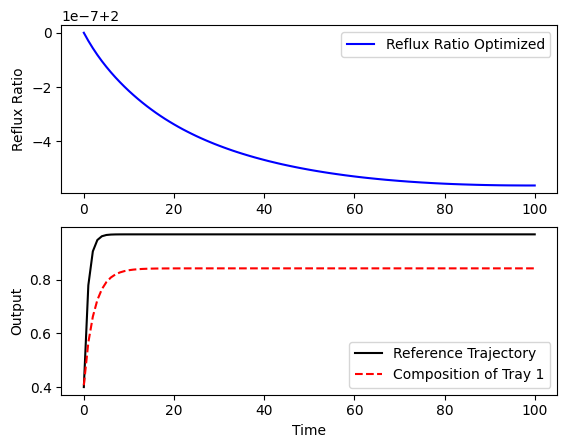

In [102]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(m.time,rr.value,'b-',label='Reflux Ratio Optimized')
plt.legend()
plt.ylabel('Reflux Ratio')
plt.subplot(2,1,2)
plt.plot(m.time,results['v1.tr'],'k-',label='Reference Trajectory')
plt.plot(m.time,y[1].value,'r--',label='Composition of Tray 1')
plt.ylabel('Output')
plt.xlabel('Time')
plt.legend(loc='best')

In [69]:
results.keys()

dict_keys(['time', 'i731', 'i732', 'i733', 'i734', 'i735', 'i736', 'i737', 'i738', 'i739', 'i740', 'i741', 'i742', 'i743', 'i744', 'i745', 'i746', 'i747', 'i748', 'i749', 'i750', 'i751', 'i752', 'i753', 'i754', 'i755', 'i756', 'i757', 'i758', 'i759', 'i760', 'i761', 'i762', 'i763', 'i764', 'i765', 'i766', 'i767', 'i768', 'i769', 'i770', 'i771', 'i772', 'p1', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20', 'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'v29', 'v30', 'v31', 'v32', 'v33', 'v1.tau', 'v1.tr', 'v1.sp', 'v1.err2', 'v1.bias', 'v1.bcv', 'v1.wsp', 'v1.cost'])